In [1]:
import tensorflow as tf
import os

In [2]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpy in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
    

In [3]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt

In [4]:
data_dir='data'

In [5]:
image_exts=['jpeg','jpg','bmp','png']

In [6]:
import numpy as np

In [12]:
data=tf.keras.utils.image_dataset_from_directory('data',batch_size=64) #this builds the dataset

Found 1218 files belonging to 11 classes.


In [13]:
data_iterator=data.as_numpy_iterator() # to iterate as data isnt iterable. it is genetared on the fly

In [14]:
batch=data_iterator.next()

In [15]:
batch[0].shape #images represented as numpy arrays

(64, 256, 256, 3)

In [16]:
batch[1] #represents which image belongs to which class

array([ 1,  0,  4,  7,  8,  0,  0,  7,  2,  6,  8,  7,  8,  2,  6,  9,  7,
        0,  3,  9,  8,  8, 10,  7,  2,  3, 10, 10, 10,  9,  5, 10,  2,  6,
        7, 10,  9,  5,  8, 10,  3,  4,  8,  8,  1,  0,  9,  6,  1,  1,  1,
        4,  3,  8,  1,  2,  9,  2, 10,  7,  2,  5,  5,  0])

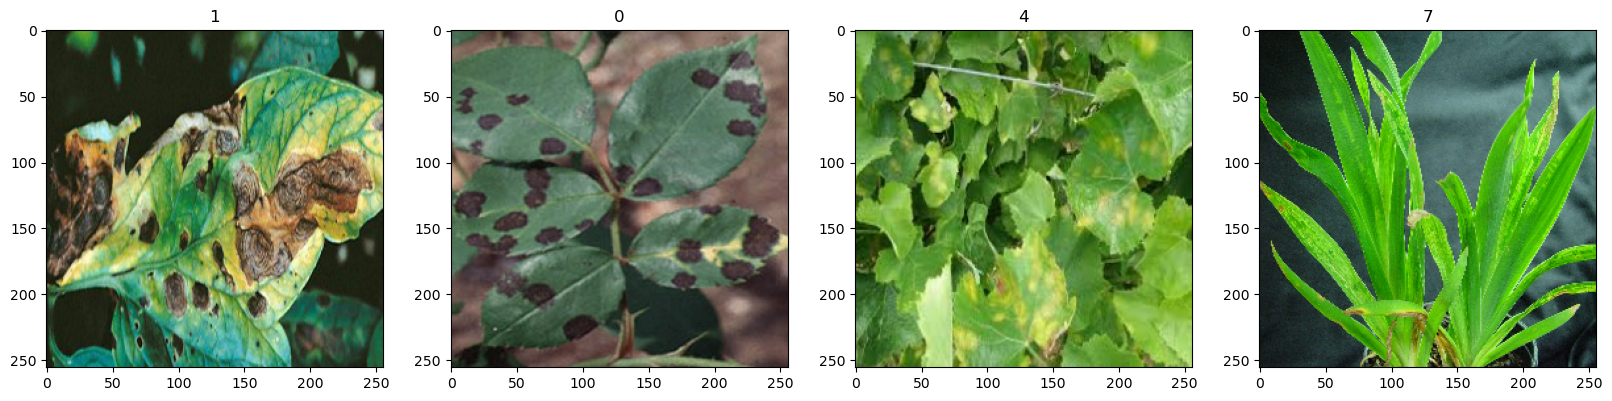

In [17]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [18]:
data=data.map(lambda x,y:(x/255,y))

In [19]:
scaled_iterator=data.as_numpy_iterator()

In [20]:
batch=scaled_iterator.next()

In [21]:
batch[0].max()

1.0

In [22]:
len(data)

20

In [23]:
train_size=int(len(data)*0.7)
val_size=int(len(data)*0.2)
test_size=int(len(data)*0.1)

In [24]:
test_size

2

In [25]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

In [26]:
len(test)

2

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Conv2D, MaxPooling2D,Dense,Flatten,Dropout

In [28]:
model=Sequential()

In [29]:
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(255, 255, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(11, activation='softmax'))
# model.add(Dense(1,activation='sigmoid')) it is for 2 outputs

C:\aiml\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),  # For sparse labels (integer labels)
              metrics=['accuracy'])


In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 253, 253, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 126, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,699,195 (14.11 MB)

 Trainable params: 3,699,195 (14.11 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
logdir='logs'

In [33]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
hist=model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.1024 - loss: 2.5989 - val_accuracy: 0.1406 - val_loss: 2.3833
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 288ms/step - accuracy: 0.1420 - loss: 2.3778 - val_accuracy: 0.1406 - val_loss: 2.3622
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.1956 - loss: 2.3235 - val_accuracy: 0.3789 - val_loss: 2.1942
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 302ms/step - accuracy: 0.3438 - loss: 2.1586 - val_accuracy: 0.5234 - val_loss: 1.8086
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 0.4637 - loss: 1.7449 - val_accuracy: 0.5938 - val_loss: 1.4811
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 305ms/step - accuracy: 0.5758 - loss: 1.3903 - val_accuracy: 0.7070 - val_loss: 1.1354
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 323ms/step - accuracy: 0.7134 - loss: 1.0582 - val_accuracy: 0.8086 - val_loss: 0.9450
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.7695 - loss: 0.8019 - val_accuracy: 0.

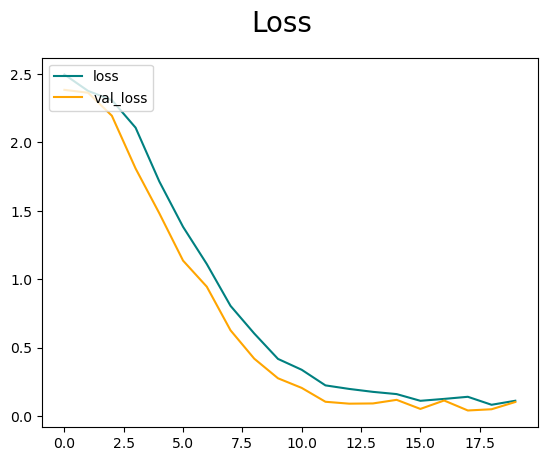

In [35]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

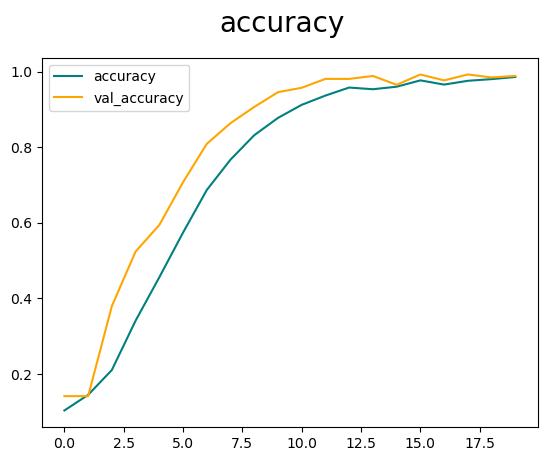

In [36]:
fig=plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [37]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [38]:
pre=Precision()
re=Recall()
acc=BinaryAccuracy()

In [40]:


# Assuming you have pre, re, acc metrics defined already
for batch in test.as_numpy_iterator():
    X, y = batch
    y_true_one_hot = tf.keras.utils.to_categorical(y, num_classes=11)
    yhat = model.predict(X)
    
    # Update state of metrics with one-hot encoded y_true and yhat
    pre.update_state(y_true_one_hot, yhat)
    re.update_state(y_true_one_hot, yhat)
    acc.update_state(y_true_one_hot, yhat)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [41]:
print(pre.result().numpy()," ",re.result().numpy()," ",acc.result().numpy())

0.9846154   0.969697   0.9958677


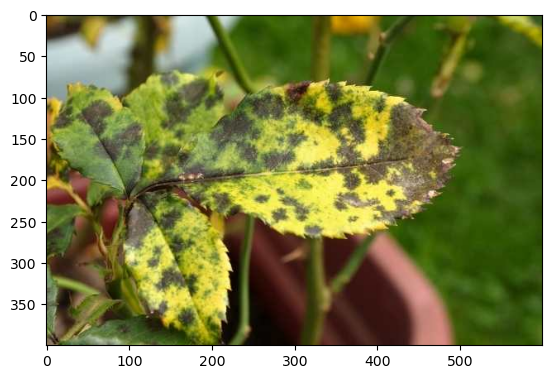

In [47]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread('test.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for displaying correctly in matplotlib
plt.imshow(img_rgb)
plt.show()

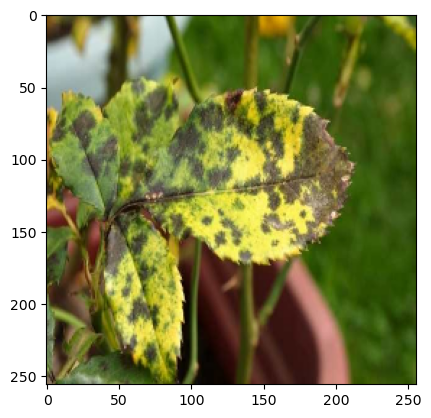

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class is blackspot


In [48]:
resize = tf.image.resize(img_rgb, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

# Normalize the image
normalized_img = resize / 255.0

yhat = model.predict(np.expand_dims(normalized_img, 0))

class_names = ['blackspot', 'blight', 'canker', 'Clubroot', 'downey mildew', 
               'greymold', 'leafspot', 'mosaic', 'powdery mildew', 'rust', 'wilt']

predicted_class_index = np.argmax(yhat)
predicted_class_name = class_names[predicted_class_index]
print(f'Predicted class is {predicted_class_name}')


In [49]:
from tensorflow.keras.models import load_model

In [51]:
model.save(os.path.join('models','plantdis.keras'))

In [52]:
new=load_model(os.path.join('models','plantdis.keras'))

C:\aiml\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
